# Verifying the SpeechT5 model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Put this notebook at the same level as the `SpeechT5` repo.

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- To run on CPU: In `speecht5/sequence_generator.py`, comment out where it does `.to(device="cuda")`

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `speecht5_base_asr.pt` and `t5_transformer_lm.pt` from https://huggingface.co/ajyy/SpeechT5

You also need an input audio file, any WAV at 16 kHz will do.

In [1]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load audio and preprocess

In [230]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/141231/1272-141231-0020.flac"

In [182]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/128104/1272-128104-0000.flac"

In [231]:
import soundfile as sf
wav_data, cur_sample_rate = sf.read(input_file)
wav_data.shape, cur_sample_rate

((69120,), 16000)

NOTE: The `Wav2Vec2FeatureExtractor` does not make sure the audio file is mono. If it has shape `(2, length)` or even `(1, length)` then the output from the feature extractor is incorrect!

The `do_normalize` option is False for the SpeechT5 ASR model.

In [282]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(do_normalize=False, return_attention_mask=True)

In [283]:
inputs = feature_extractor(wav_data, sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs["input_values"].shape

torch.Size([1, 69120])

In [234]:
# for testing padding mask
inputs["attention_mask"][:, 40000:] = 0

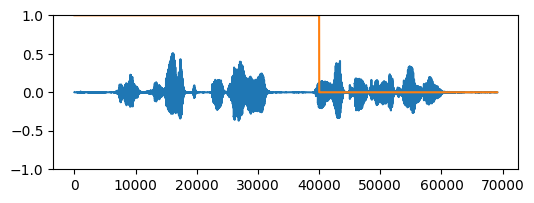

In [235]:
plt.figure(figsize=(6, 2))
plt.plot(inputs["input_values"][0])
plt.plot(inputs["attention_mask"][0])
plt.ylim(-1, 1)
plt.show()

Transform multiple inputs into a single padded batch:

In [10]:
input_file2 = "/Users/matthijs/Documents/FILES/HuggingFace/S2S/textless/AUDIO_DIR/selfdestruct.wav"
wav_data2, cur_sample_rate2 = sf.read(input_file2)
wav_data2.shape, cur_sample_rate2

((128632,), 16000)

In [11]:
inputs2 = feature_extractor([wav_data, wav_data2], sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs2["input_values"].shape

torch.Size([2, 128632])

The original model used a `padding_mask` as input, where False means no padding. The `Wav2Vec2FeatureExtractor` can return an `attention_mask`, where 1 means no padding.

In [12]:
inputs2["attention_mask"]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [93]:
# inputs = inputs2

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint. I used `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task s2t \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [345]:
from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForConditionalGeneration, 
    SpeechT5ForCTC, 
    Wav2Vec2FeatureExtractor,
)


In [346]:
config = SpeechT5Config()
hf_model = SpeechT5Model(config)

In [347]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr"

Note that loading should work OK for both the base class `SpeechT5Model` and `SpeechT5ForCTC`.

In [348]:
#hf_model = SpeechT5Model.from_pretrained(model_checkpoint)

In [349]:
hf_model = SpeechT5ForConditionalGeneration.from_pretrained(model_checkpoint)

In [350]:
hf_model.eval()

SpeechT5ForConditionalGeneration(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5SpeechEncoder(
      (prenet): SpeechT5SpeechEncoderPrenet(
        (feature_encoder): SpeechT5FeatureEncoder(
          (conv_layers): ModuleList(
            (0): SpeechT5GroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (2): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (3): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
    

In [351]:
# Verify the attention layer weights are correct
# for i in range(len(hf_model.speecht5.encoder.layers)):
#     print(i, "k_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.weight == orig_model.encoder.layers[i].self_attn.k_proj.weight))
#     print(i, "k_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.bias == orig_model.encoder.layers[i].self_attn.k_proj.bias))
#     print(i, "v_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.weight == orig_model.encoder.layers[i].self_attn.v_proj.weight))
#     print(i, "v_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.bias == orig_model.encoder.layers[i].self_attn.v_proj.bias))
#     print(i, "q_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.weight == orig_model.encoder.layers[i].self_attn.q_proj.weight))
#     print(i, "q_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.bias == orig_model.encoder.layers[i].self_attn.q_proj.bias))
#     print(i, "out_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.weight == orig_model.encoder.layers[i].self_attn.out_proj.weight))
#     print(i, "out_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.bias == orig_model.encoder.layers[i].self_attn.out_proj.bias))
#     print("---")

# print("pos_emb weight", torch.all(hf_model.speecht5.encoder.pos_emb.pe_k.weight == orig_model.encoder.pos_emb.pe_k.weight))

Run a single forward pass. This should run the encoder, decoder, and the relevant pre- and postnets.

In [352]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(**inputs)

type(hf_outputs)

tuple

In [353]:
# Using no attention_mask
# with torch.no_grad():
#      hf_outputs = hf_model.speech_encoder_prenet(input_values=inputs["input_values"])

# type(hf_outputs)

In [354]:
# list(hf_outputs.keys())

In [355]:
# hf_outputs["extract_features"].shape

In [356]:
# hf_outputs["extract_features"]

In [357]:
# hf_outputs["hidden_states"].shape

In [358]:
# hf_outputs["hidden_states"]

In [359]:
[x.shape for x in hf_outputs if hasattr(x, "shape")]

[torch.Size([1, 215, 768]), torch.Size([1, 215])]

In [360]:
hf_outputs[0]

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 8.1539, -5.4359,  5.8689,  ...,  1.0349,  4.1734,  1.4926],
         [ 0.8112, -3.6817,  5.7369,  ..., -0.6757,  2.3840,  1.2404],
         [ 2.7066, -3.5683,  6.5834,  ...,  0.4324,  2.7151,  1.5720]]])

In [361]:
hf_encoder_input = hf_outputs[0]
hf_encoder_attention_mask = hf_outputs[1]

## Load the original model

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [362]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [363]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "s2t"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [364]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [365]:
checkpoint = torch.load("../weights/SpeechT5/speecht5_base_asr.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [366]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [367]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [368]:
#list(checkpoint["model"].keys())

In [369]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [370]:
# orig_model.decoder.layers[0].encoder_attn

## Verify speech encoder prenet output

This first uses the `speech_encoder_prenet` to convert the raw audio data into embeddings of shape `(batch, sequence_length, 768)`. The sequence length is roughly `number of audio samples / 320`, so there is one vector every 20 ms.

In [371]:
source = inputs["input_values"]
source.shape

torch.Size([1, 69120])

In [372]:
padding_mask = torch.BoolTensor(source.shape).fill_(False)

In [373]:
padding_mask = torch.BoolTensor((1 - inputs["attention_mask"]).bool())
padding_mask

tensor([[False, False, False,  ..., False, False, False]])

In [374]:
# This doesn't work on the original model
#padding_mask = None

In [375]:
encoder_input, encoder_padding_mask = orig_model.speech_encoder_prenet(
    source, padding_mask=padding_mask, mask=False
)

In [376]:
# encoder_input = orig_model.speech_encoder_prenet.feature_extractor(source)
# encoder_input.shape

In [377]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([1, 215, 768]), torch.Size([1, 215]))

In [378]:
encoder_input

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 8.1539, -5.4359,  5.8689,  ...,  1.0349,  4.1734,  1.4926],
         [ 0.8112, -3.6817,  5.7369,  ..., -0.6757,  2.3840,  1.2404],
         [ 2.7066, -3.5683,  6.5834,  ...,  0.4324,  2.7151,  1.5720]]])

In [379]:
#encoder_padding_mask

If the weights and model were converted correctly, this should report zero or a very small number:

In [380]:
# torch.max(torch.abs(encoder_input - hf_outputs["hidden_states"]))
torch.max(torch.abs(encoder_input - hf_outputs[0]))

tensor(0.)

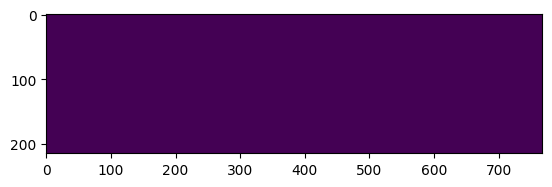

In [381]:
# plt.imshow(torch.abs(encoder_input - hf_outputs["hidden_states"]).numpy()[0] > 1e-5)
plt.imshow(torch.abs(encoder_input - hf_outputs[0]).numpy()[0] > 1e-5)

The line that is different is where the padding mask goes from 1 to 0; the original model handles this a little different than we do.

In [382]:
# torch.max(torch.abs(encoder_input - hf_outputs["extract_features"]))

In [383]:
# torch.abs(encoder_input - hf_outputs["last_hidden_state"])

## Verify Transformer encoder output

In [384]:
# Run it with the original's speech prenet input:
# with torch.no_grad():
#     encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [385]:
# Run it with our input, which is slightly different (see above)
with torch.no_grad():
    encoder_output = orig_model.encoder(hf_encoder_input, ~hf_encoder_attention_mask)

In [386]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([215, 1, 768])
encoder_padding_mask shape torch.Size([1, 215])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([215, 1, 81])


In [387]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[-0.3412, -0.1983, -0.5504,  ...,  0.3371, -0.7611,  0.2468],
         [-0.3532, -0.1819, -0.6027,  ...,  0.2886, -0.8502,  0.1505],
         [-0.4093, -0.1701, -0.6913,  ...,  0.2886, -0.7586, -0.0191],
         ...,
         [ 0.2191,  0.1308, -0.2119,  ...,  0.2059, -0.7364,  0.2486],
         [ 0.0395,  0.0048, -0.3112,  ...,  0.1692, -0.7535,  0.2188],
         [-0.0338, -0.1440, -0.3480,  ...,  0.2844, -0.7159,  0.1947]]])

In [388]:
encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

tensor([[[ -9.4632,  -9.6230,  -9.6073,  ...,  -9.5406,  -9.3881,  12.4264],
         [ -9.8169,  -9.9027,  -9.9673,  ...,  -9.8993,  -9.7949,  13.0776],
         [-10.9712, -11.0219, -11.0252,  ..., -11.0365, -10.9394,  14.6879],
         ...,
         [ -8.2366,  -8.3445,  -8.3155,  ...,  -8.4186,  -8.0964,  10.4814],
         [ -8.7586,  -8.9771,  -8.8052,  ...,  -8.8178,  -8.5105,  11.1125],
         [ -9.6384, -10.0383,  -9.7550,  ...,  -9.7551,  -9.3112,  11.0622]]])

In [389]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [390]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.wrapped_encoder(
         hidden_states=hf_encoder_input,
         attention_mask=hf_encoder_attention_mask,
#          input_values=inputs.input_values,
#          attention_mask=inputs.attention_mask,
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [391]:
hf_outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.3412, -0.1983, -0.5504,  ...,  0.3371, -0.7611,  0.2468],
         [-0.3532, -0.1819, -0.6027,  ...,  0.2886, -0.8502,  0.1505],
         [-0.4093, -0.1701, -0.6913,  ...,  0.2886, -0.7586, -0.0191],
         ...,
         [ 0.2191,  0.1308, -0.2119,  ...,  0.2059, -0.7364,  0.2486],
         [ 0.0395,  0.0048, -0.3112,  ...,  0.1692, -0.7535,  0.2188],
         [-0.0338, -0.1440, -0.3480,  ...,  0.2844, -0.7159,  0.1947]]]), hidden_states=None, attentions=None)

In [392]:
list(hf_outputs.keys())

['last_hidden_state']

In [393]:
hf_outputs["last_hidden_state"].shape

torch.Size([1, 215, 768])

In [394]:
hf_outputs["last_hidden_state"]

tensor([[[-0.3412, -0.1983, -0.5504,  ...,  0.3371, -0.7611,  0.2468],
         [-0.3532, -0.1819, -0.6027,  ...,  0.2886, -0.8502,  0.1505],
         [-0.4093, -0.1701, -0.6913,  ...,  0.2886, -0.7586, -0.0191],
         ...,
         [ 0.2191,  0.1308, -0.2119,  ...,  0.2059, -0.7364,  0.2486],
         [ 0.0395,  0.0048, -0.3112,  ...,  0.1692, -0.7535,  0.2188],
         [-0.0338, -0.1440, -0.3480,  ...,  0.2844, -0.7159,  0.1947]]])

In [395]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(0.)

## Verify CTC model

This model only needs the encoder portion.

This uses the same checkpoint as before: `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Run the following to convert, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task ctc \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [396]:
# hf_model_ctc = SpeechT5ForCTC(config)

In [397]:
model_checkpoint_ctc = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc"
hf_model_ctc = SpeechT5ForCTC.from_pretrained(model_checkpoint_ctc)

In [398]:
# Run the full model:
with torch.no_grad():
     hf_outputs = hf_model_ctc(**inputs)

# Run without attention_mask:
# with torch.no_grad():
#     hf_outputs = hf_model_ctc(input_values=inputs["input_values"])

type(hf_outputs)

transformers.modeling_outputs.CausalLMOutput

In [399]:
torch.max(torch.abs(encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2)) - hf_outputs[0]))

tensor(0.)

In [400]:
probs = torch.nn.functional.softmax(hf_outputs[0], dim=-1, dtype=torch.float32)
probs = probs.argmax(dim=-1)

In [401]:
probs

tensor([[80, 80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4, 46, 80, 80, 16, 80, 80, 12, 12,  6,  6, 80, 80, 80, 80,
         80,  4,  4,  4,  6,  6, 11, 11, 13, 13, 13, 80, 16, 16, 80, 80, 80, 80,
         12, 12,  6,  6, 80, 80, 80, 80, 80, 80, 80, 80,  4,  4,  4, 80, 80,  7,
          9, 14, 14,  4,  4, 80, 24, 80, 80, 80, 80,  5, 13, 13, 80, 80, 13, 13,
         80, 22, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4, 80,  7,  7,  9, 14,
         14, 80,  4,  4,  4, 27, 80, 80, 10, 80, 17, 17,  6,  6,  6,  8, 13, 13,
         13, 22, 22, 80, 80,  4,  4,  6,  8,  8, 80,  4,  6,  6, 11,  5,  5,  4,
         12, 12, 80,  6,  6, 13, 13, 80, 80,  8, 80,  9,  9, 80, 21, 21, 80, 80,
          5, 13, 13, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]])

In [402]:
# print(tgt_dict.string(probs[0]))

In [403]:
for i in range(probs.shape[0]):
    print(tokenizer.decode(tgt_dict.string(probs[i])).replace("<ctc_blank>", ""))

                jusstt   tthhrrruusstt   andd  perrrry       aandd   vicctttorrryy  too tthee ssttrronnggerr


Calculate loss:

In [409]:
with torch.no_grad():
     hf_outputs = hf_model_ctc(
         **inputs, 
         labels=torch.tensor(
           [ 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13, ]
         ),
         output_hidden_states=True,
         return_dict=True,
     )

In [410]:
hf_outputs.loss

tensor(1208.0262)

## Verify text decoder prenet

First this calls `text_decoder_prenet`:

In [411]:
beam_size = 5
tokens = torch.tensor([2] * beam_size).reshape(beam_size, -1)
tokens.shape

torch.Size([5, 1])

In [412]:
incremental_state = {}  # no incremental state on first step

In [413]:
with torch.no_grad():
    prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state)

In [414]:
# Note: misleading name; these are not the actual tokens but their embeddings!
prev_output_tokens.shape

torch.Size([5, 1, 768])

In [415]:
tgt_mask

In [416]:
incremental_state

{}

In [417]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.prenet(
         input_ids=tokens,
#          attention_mask=hf_encoder_attention_mask,
#          attention_mask=inputs.attention_mask,
     )

type(hf_outputs)

torch.Tensor

In [418]:
hf_outputs.shape

torch.Size([5, 1, 768])

In [419]:
torch.max(torch.abs(prev_output_tokens - hf_outputs))

tensor(0.)

## Verify Transformer decoder output

In [421]:
bsz = source.size(0)
new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
encoder_outs = orig_model.encoder.reorder_encoder_out(encoder_output, new_order)

In [426]:
prev_output_tokens

tensor([[[1.1074, 1.1042, 1.0387,  ..., 0.9619, 1.0463, 0.8678]],

        [[1.1074, 1.1042, 1.0387,  ..., 0.9619, 1.0463, 0.8678]],

        [[1.1074, 1.1042, 1.0387,  ..., 0.9619, 1.0463, 0.8678]],

        [[1.1074, 1.1042, 1.0387,  ..., 0.9619, 1.0463, 0.8678]],

        [[1.1074, 1.1042, 1.0387,  ..., 0.9619, 1.0463, 0.8678]]])

In [427]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_outs,
        incremental_state=incremental_state,
    )

In [428]:
decoder_output.shape

torch.Size([5, 1, 768])

In [429]:
decoder_output

tensor([[[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]]])

In [430]:
#[x.shape for x in extra["attn"]]

In [431]:
# [x.shape for x in extra["inner_states"]]

In [432]:
hf_model.speecht5.decoder.wrapped_decoder.training

False

In [433]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.wrapped_decoder(
         hidden_states=prev_output_tokens,
         #attention_mask=tgt_mask,
         encoder_hidden_states=encoder_outs["encoder_out"][0].permute((1, 0, 2)),
         encoder_attention_mask=torch.tile(hf_encoder_attention_mask, (5, 1)),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [434]:
list(hf_outputs.keys())

['last_hidden_state', 'past_key_values']

In [435]:
hf_outputs["last_hidden_state"].shape

torch.Size([5, 1, 768])

In [436]:
hf_outputs["last_hidden_state"]

tensor([[[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]],

        [[-0.4891, -0.3359, -0.2168,  ..., -0.2537, -0.4110, -0.0280]]])

In [437]:
torch.max(torch.abs(decoder_output - hf_outputs["last_hidden_state"]))

tensor(4.7684e-07)

Close enough! I would rather see 0.0 but this looks like numerical precision differences for 32-bit floats.

## Verify text decoder postnet output

In [438]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [439]:
lprobs.shape

torch.Size([5, 1, 81])

In [440]:
lprobs[0]

tensor([[-21.8423, -21.9258,   1.3216, -21.8823,  16.4646,   0.0780,   0.3366,
          -1.1414,  -0.4092,  -1.6770,  -0.1935,   0.0583,  -0.1176,  -0.8975,
          -2.3240,  -1.1076,  -0.8370,  -2.3857,  -0.8850,  -0.6924,   1.0384,
          -0.1168,  -2.9756, -21.9991,  -1.3356,   0.6164, -21.9502,  -3.0913,
          -2.4927, -21.8967, -21.9306,   0.2664, -22.0258, -21.8972, -21.8948,
         -21.9652, -21.9363,  -5.7837, -21.9041, -21.9971, -21.8730, -21.9515,
         -21.9392, -21.9500, -21.9247,  -2.4618,  -1.3141, -21.8651, -21.9030,
         -22.0258, -21.9018, -21.9822, -21.8786, -21.8657, -21.9147, -21.8601,
         -21.9148,  -5.8765, -21.9306, -21.8924, -21.9506, -21.9957, -21.9345,
         -21.9068, -21.9166, -21.9429, -21.9176, -21.9675, -21.9592, -21.9133,
         -21.8348, -21.9442, -21.8758, -21.9156, -21.8621, -21.9204, -21.8856,
         -21.9069, -21.8934, -20.5559, -21.8836]])

In [441]:
with torch.no_grad():
    lprobs_hf = hf_model.text_decoder_postnet(decoder_output)

In [442]:
lprobs_hf.shape

torch.Size([5, 1, 81])

In [443]:
lprobs_hf[0]

tensor([[-21.8423, -21.9258,   1.3216, -21.8823,  16.4646,   0.0780,   0.3366,
          -1.1414,  -0.4092,  -1.6770,  -0.1935,   0.0583,  -0.1176,  -0.8975,
          -2.3240,  -1.1076,  -0.8370,  -2.3857,  -0.8850,  -0.6924,   1.0384,
          -0.1168,  -2.9756, -21.9991,  -1.3356,   0.6164, -21.9502,  -3.0913,
          -2.4927, -21.8967, -21.9306,   0.2664, -22.0258, -21.8972, -21.8948,
         -21.9652, -21.9363,  -5.7837, -21.9041, -21.9971, -21.8730, -21.9515,
         -21.9392, -21.9500, -21.9247,  -2.4618,  -1.3141, -21.8651, -21.9030,
         -22.0258, -21.9018, -21.9822, -21.8786, -21.8657, -21.9147, -21.8601,
         -21.9148,  -5.8765, -21.9306, -21.8924, -21.9506, -21.9957, -21.9345,
         -21.9068, -21.9166, -21.9429, -21.9176, -21.9675, -21.9592, -21.9133,
         -21.8348, -21.9442, -21.8758, -21.9156, -21.8621, -21.9204, -21.8856,
         -21.9069, -21.8934, -20.5559, -21.8836]])

In [444]:
torch.max(torch.abs(lprobs - lprobs_hf))

tensor(0.)

## Use the `transformers` generator loop:

Run the full model to make sure this doesn't give any errors:

In [445]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         decoder_input_ids=torch.tensor([[3, 4, 5]]),
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [446]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [447]:
hf_outputs["logits"].shape

torch.Size([1, 3, 81])

Also calculate loss:

In [448]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[2,  4, 18, 10, 12,  6,  5]]),
         labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13]]),
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [449]:
hf_outputs["logits"].shape

torch.Size([1, 7, 81])

In [450]:
hf_outputs["loss"]

tensor(2.8065)

Generator loop:

In [451]:
hf_outputs = hf_model.generate(inputs.input_values, max_length=100)
# hf_outputs = hf_model.generate(inputs.input_values, num_beams=5, max_length=100) #, bos_token_id=2)
# hf_outputs = hf_model.generate(torch.rand(1, 10000), num_beams=5, max_length=10)

In [452]:
hf_outputs.shape

torch.Size([1, 52])

In [453]:
hf_outputs

tensor([[ 2,  4, 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13,  2]])

In [454]:
for i in range(probs.shape[0]):
    print(tgt_dict.string(hf_outputs))
    print(tokenizer.decode(tgt_dict.string(hf_outputs)))

▁ j u s t ▁ t h r u s t ▁ a n d ▁ p a r r y ▁ a n d ▁ v i c t o r y ▁ t o ▁ t h e ▁ s t r o n g e r
just thrust and parry and victory to the stronger


In [455]:
[tgt_dict[x] for x in range(5)]

['<s>', '<pad>', '</s>', '<unk>', '▁']

For comparison, Speech2Text:

In [169]:
>>> import torch
>>> from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration
>>> from datasets import load_dataset

>>> model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
>>> processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

>>> ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

>>> inputs = processor(
...     ds[0]["audio"]["array"], sampling_rate=ds[0]["audio"]["sampling_rate"], return_tensors="pt"
... )
>>> input_features = inputs.input_features

>>> generated_ids = model.generate(inputs=input_features)

>>> transcription = processor.batch_decode(generated_ids)[0]
>>> transcription
#'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

Reusing dataset librispeech_asr_dummy (/Users/matthijs/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

Test other methods:

In [79]:
# hf_model.prune_heads({1: [0, 2], 2: [2,3 ]})